## Sistema de Recomendación

### Alumno: Jose Manuel de la Torre

En este ejercicio práctico de la asignatura de Big Data se plantea realizar un sistema de recomendación de películas, basándonos en los ficheros adjuntados en el aula virtual, que contienen información sobre movies, ratings y usuarios. 
Para completar el ejercicio se utilizará el algoritmo ALS (Alternating Least Squares), que funciona realizando factorización de matrices. 
Se decide usar este algoritmo después de cursar el curso en datacamp "Building Recommendation Engines with PySpark", y seguir las pautas y recomendaciones aprendidas en el mismo.

In [1]:
#Importación de librerías necesarias
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import IntegerType
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

Y creamos una sesión de Spark, con la que trabajaremos a los largo de este notebook

In [2]:
spark = SparkSession.builder.getOrCreate()

### Carga de Datos

Pasamos a cargar los datos a un dataframe que nombraremos df, y del cual haremos uso extensivo a lo largo de este proyecto. Algunos parámetros son bastante obvios de configurar con tan solo mirar el conjunto de datos rápidamente, solamente es importante mencionar que defino la opción de separador como ",", cuando claramente el fichero esta dividido por "::", porque spark no me permite definir como divisor una cadena de más de un elemento, y por tanto a continuación tendremos que dividir el dataset leído por este string de doble punto.

In [3]:
df = spark.read.format("csv") \
  .option("inferSchema", False) \
  .option("header", False) \
  .option("sep", ",") \
  .load("ml-1m/ratings.csv")

df.show(5)

+--------------------+
|                 _c0|
+--------------------+
|1::1193::5::97830...|
|1::661::3::978302109|
|1::914::3::978301968|
|1::3408::4::97830...|
|1::2355::5::97882...|
+--------------------+
only showing top 5 rows



Como podemos apreciar, hemos leído correctamente el dataset que nos interesa, pero tenemos un primer contratiempo, no se encuentra estructurado y nos interesa a continuación convertir la columna "_c0", a un conjunto de columnas usuario, Id de película y rating de la misma. 

In [4]:
split_char = pyspark.sql.functions.split(df['_c0'], '::')
df = df.withColumn('userId', split_char.getItem(0))
df = df.withColumn('movieId', split_char.getItem(1))
df = df.withColumn('rating', split_char.getItem(2))

df=df.drop("_c0")
df.show(5)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|   1193|     5|
|     1|    661|     3|
|     1|    914|     3|
|     1|   3408|     4|
|     1|   2355|     5|
+------+-------+------+
only showing top 5 rows



Con el dataset en la estructura que nos interesa, hacemos la comprobación de los tipos de datos que contiene por columna nuestro dataset. La función printSchema, nos da esta respuesta en una sencilla instrucción. Para a continuación convertirlo a los tipos de datos que deseamos manipula para el ejercicio.

In [5]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)



In [6]:
# Tell Spark to convert the columns to the proper data types
df = df.select(df.userId.cast("integer"), 
               df.movieId.cast("integer"), 
               df.rating.cast("double"))
df.show(5)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|   1193|   5.0|
|     1|    661|   3.0|
|     1|    914|   3.0|
|     1|   3408|   4.0|
|     1|   2355|   5.0|
+------+-------+------+
only showing top 5 rows



In [7]:
# Dividimos el conjunto en entrenamiento y test
(train, test) = df.randomSplit([0.80, 0.20], seed = 1234)

## Modelo ALS

El algoritmo ALS presenta una alternativa altamente paralelizable para la optimización de la función de coste que implica la factorización de la matriz de interacciones usuarios-ítems con regularización de pesos.

La API de Apache Spark para Python, PySpark, en su librería Mlib ofrece una implementación paralelizada del modelo ALS para Filtrado Colaborativo que usaremos en el desarrollo del sistema de recomendación basado en predicción de ratings.

Se define el modelo ALS a continuación, por el momento sin incluirle hiperparámetros al mismo, solamente creamos el objeto de tipo modelo ALS por el momento, definiendo las columnas que utilizaremos y algunos detalles necesarios. 

In [8]:
# Build generic ALS model without hyperparameters
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", 
            coldStartStrategy="drop", nonnegative = True, 
            implicitPrefs = False)

### Hiperparámetros

Se definene el conjunto de hiperparámetros que probaremos en nuestro modelo mediante una validación cruzada que se define más adelante, y por motivos de recursos de computador no realizamos un chequeo extensivo de los parámetros, ya que serían necesarios recursos realmente potentes para encontrar los hiperparámetros "perfectos" para el modelo que se crea.

In [9]:
## Tell Spark what values to try for each hyperparameter
ranks = [5, 10]
Iteration = [5, 10]
regularization = [.05, .1]

param_grid = ParamGridBuilder()\
    .addGrid(als.rank, ranks)\
    .addGrid(als.maxIter, Iteration)\
    .addGrid(als.regParam, regularization)\
    .build()

In [10]:
# Tell Spark how to evaluate model performance           
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", 
            predictionCol="prediction")

In [11]:
# Build cross validation step using CrossValidator 
cv = CrossValidator(estimator = als,
                    estimatorParamMaps = param_grid,
                    evaluator = evaluator,
                    numFolds = 5)

### Entrenamiento del Modelo

Por motivos de coste computacional, no se recomienda ejecutar el chunk siguiente ya que puede tardar varias horas en su ejecución para encontrar mediante la validación cruzada el mejor modelo para el conjunto de datos.

In [ ]:
# Run the cv on the training data                    
model = cv.fit(train)

# Extract best combination of values from cross validation
best_model = model.bestModel

# Complete the code below to extract the ALS model parameters
print("**Best Model**")

In [20]:
# # Print "Rank"
print("  Rank:", model.getRank())
# # Print "MaxIter"
print("  MaxIter:", model.getMaxIter())
# # Print "RegParam"
print("  RegParam:", model.getRegParam())

Se obtienen como resultado de la ejecución anterior los parámetros de:

<b>Rank</b> = 10
<b>Regularización</b> = 0.1
<b>Iteraciones</b> = 10

Y por tanto, creamos a continuación un modelo con los hiperparámetros obtenidos, y también a modo de prueba y para poder ejecutar varias veces el notebook, ya que el experimento con Cross Validation puede tardar demasiado tiempo, del cual no se dispone.


In [12]:
#Modelo final
als = ALS(regParam=0.1, rank=10, maxIter=10, userCol="userId", 
          itemCol="movieId", ratingCol="rating",  seed=42, nonnegative=True, 
          implicitPrefs=False, coldStartStrategy="drop")
model = als.fit(train)

## Distribución Ratings

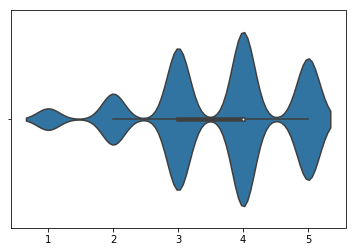

In [24]:
import seaborn as sns

# Convert Spark dataframe to Pandas to plot data distribution
pandas_df = df.limit(10000).toPandas()
# Ratings distribution for a sample of 10000 users
sns.violinplot([pandas_df.rating])

Se muestra en la figura anterior un pequeño vistazo a la distribución que queremos testear, pudiendo resaltar, que un resultado cercano a los 4 puntos es predecible, al menos sin analizar los datos con mucho detalle. Pero se puede apreciar, como las opiniones positivas, o mayores o iguales a 3 prevalecen en el dataset.

### Resultados 

Se evalua las predicciones en el siguiente cuadro de código, con la métrica RMSE ó Root Mean Square Error, que nos mide cuando diferente es un conjunto de datos con respecto a otro, en otras palabras compara los valores predecidos con los valores reales almacenados en test.

In [15]:
# Generate test set predictions and evaluate using RMSE
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)

# Print evaluation metrics and model parameters
print ("**Best Model**")
print ("RMSE = ", rmse)

**Best Model**
RMSE =  0.8745238748925711


### Predicciones

Por último, y para una validación final de resultados al menos de forma visual, se predice en el conjunto de test, eliminando la columna ratings, para obtener y mostrar en el último chunk del proyecto una muestra de 10 filas de las predicciones que es capaz de obtener el modelo creado. 

In [16]:
test_no_rating = test.drop("rating")

predictions = model.transform(test_no_rating)
ratings_predictions = test.join(predictions,["userId","movieId"])

In [18]:
recommendations=ratings_predictions.filter(ratings_predictions["userID"]==1)\
                    .orderBy(ratings_predictions["prediction"].desc())
recommendations.show(10)

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|     1|   2762|   4.0| 4.2865815|
|     1|      1|   5.0| 4.2215652|
|     1|    150|   5.0|  4.157282|
|     1|   2398|   4.0|  4.124039|
|     1|   1270|   5.0| 4.0787444|
|     1|   1287|   5.0|  4.053317|
|     1|   1962|   4.0|  4.026748|
|     1|   2791|   4.0| 3.7300913|
|     1|    783|   4.0| 3.4054606|
|     1|     48|   5.0| 3.1469345|
+------+-------+------+----------+
only showing top 10 rows

